### Rohith Reddy Vangala
### 016762109
### Assignment - 4 Part - 1

### Note : I have made the google drive link public so you can access the files from there - https://drive.google.com/drive/folders/1Vik_uJOu1fJX2IsvvXY6Apek5ed15i09?usp=drive_link

### Git Link - https://github.com/rohithreddy66666/Deep_Learning_Assignments

### Mounting google drive to collab notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

new_folder_path = '/content/drive/My Drive/New_Assignment_4'
if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)
    print(f"Created folder: {new_folder_path}")
else:
    print(f"Folder already exists: {new_folder_path}")


Folder already exists: /content/drive/My Drive/New_Assignment_4


In [ ]:
video_path = '/content/drive/My Drive/New_Assignment_4/demo_video.mp4'  # Update this path
if os.path.exists(video_path):
    print("Video file exists and is accessible.")
else:
    print("Video file does not exist or is not accessible. Check the file path.")


Video file exists and is accessible.


In [ ]:
# Define the path for the new frames directory within your assignment folder
frames_dir = '/content/drive/My Drive/New_Assignment_4/frames'  # Adjust based on your folder structure

# Create the frames directory if it doesn't exist
if not os.path.exists(frames_dir):
    os.makedirs(frames_dir)
    print(f"Frames directory created at: {frames_dir}")
else:
    print(f"Frames directory already exists at: {frames_dir}")


Frames directory already exists at: /content/drive/My Drive/New_Assignment_4/frames


In [ ]:
!pip install torch torchvision
import cv2
import torch
from torchvision.transforms import functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
from PIL import Image

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cuda


### Extracting frames and storing it on frames folder using OPen CV

In [ ]:
video_path = '/content/drive/My Drive/New_Assignment_4/demo_video.mp4'  # Update if necessary
frames_dir = '/content/drive/My Drive/New_Assignment_4/frames'

vidcap = cv2.VideoCapture(video_path)
success, image = vidcap.read()
count = 0

while success:
    cv2.imwrite(f"{frames_dir}/frame{count:03d}.jpg", image)     # Save frame as JPEG file
    success, image = vidcap.read()
    count += 1
print(f"Extracted {count} frames.")


Extracted 225 frames.


### Displaying some of the frames

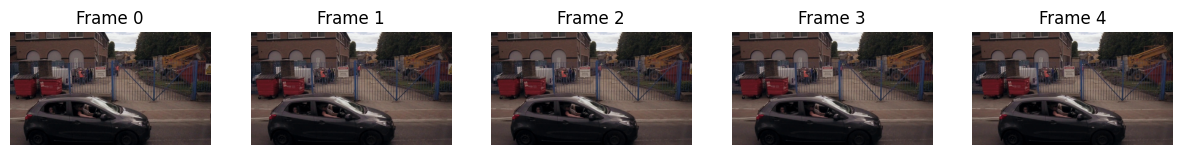

In [ ]:
# Directory where frames are saved
frames_dir = '/content/drive/My Drive/New_Assignment_4/frames'

# Number of frames to display
num_frames_to_show = 5

# Get all frame filenames
frame_files = sorted([os.path.join(frames_dir, f) for f in os.listdir(frames_dir) if f.endswith('.jpg')])

# Select a subset of frames to display
selected_frames = frame_files[:num_frames_to_show]

# Display the frames
plt.figure(figsize=(15, 10))
for i, frame_path in enumerate(selected_frames):
    plt.subplot(1, num_frames_to_show, i + 1)
    frame = Image.open(frame_path)
    plt.imshow(frame)
    plt.title(f'Frame {i}')
    plt.axis('off')
plt.show()


### Loading the pre trained Fater R-CNN model

In [ ]:
import torchvision
import torch
from torchvision.transforms import functional as F

# Check if CUDA is available and set the device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load a pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model = model.to(device)
model.eval()  # Set the model to evaluation mode


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
    'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
    'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


### Functions to draw boxes and process the frames

In [ ]:
def draw_boxes(image, prediction, threshold=0.5):
    # Convert the image from PyTorch tensor to numpy array
    image = np.array(image).copy()
    # Convert from RGB to BGR (which OpenCV uses)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Draw all boxes with a confidence score above the threshold
    for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
        if score > threshold:  # Adjust the threshold as needed
            # Convert box to integer pixel values
            box = box.cpu().numpy().astype(int)
            label_name = COCO_INSTANCE_CATEGORY_NAMES[label.cpu().item()]
            # Draw the rectangle
            cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
            # Add label and score text
            cv2.putText(image, f'{label_name}: {score:.2f}', (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2)
    return image


def process_frame(frame_path, model):
    # Load the image file
    image = Image.open(frame_path).convert("RGB")
    # Convert to tensor and move to the device
    image_tensor = F.to_tensor(image).to(device)

    # Perform inference
    model.eval()  # Make sure the model is in eval mode
    with torch.no_grad():
        prediction = model([image_tensor])[0]

    # Draw bounding boxes on the image
    result_image = draw_boxes(image, prediction)

    # Convert the result back to PIL Image for easier handling and return it
    return Image.fromarray(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))


### Saving the processed frames on google drive

In [ ]:
import os
from tqdm.notebook import tqdm
import numpy as np
output_frames_dir = '/content/drive/My Drive/New_Assignment_4/processed_frames'
if not os.path.exists(output_frames_dir):
    os.makedirs(output_frames_dir)

# Process a subset or all frames
for frame_path in tqdm(sorted(frame_files)):
    result_image = process_frame(frame_path, model)
    # Build the path for the output frame
    output_frame_path = os.path.join(output_frames_dir, os.path.basename(frame_path))
    # Save the frame with drawn bounding boxes
    result_image.save(output_frame_path)


  0%|          | 0/225 [00:00<?, ?it/s]

### Showing some of the processed frames

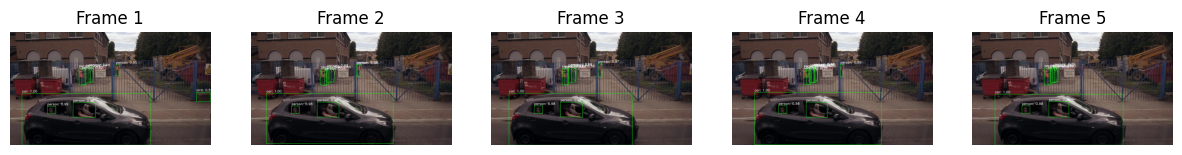

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Directory where the processed frames are saved
output_frames_dir = '/content/drive/My Drive/New_Assignment_4/processed_frames'

# Get all image files from the directory
frame_files = [os.path.join(output_frames_dir, f) for f in sorted(os.listdir(output_frames_dir)) if f.endswith('.jpg') or f.endswith('.png')]

# Number of frames you want to display
num_frames_to_display = 5  # You can change this to display more or fewer images

# Display the first few frames
plt.figure(figsize=(15, 10))  # Adjust the size as needed
for i, frame_path in enumerate(frame_files[:num_frames_to_display]):
    img = Image.open(frame_path)
    plt.subplot(1, num_frames_to_display, i + 1)  # Adjust subplot parameters as needed
    plt.imshow(img)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.title(f'Frame {i+1}')
plt.show()


### Saving Video to the google drive

In [ ]:
def compile_video(frames_dir, output_video_path, fps=30):
    frame_files = sorted([os.path.join(frames_dir, f) for f in os.listdir(frames_dir) if f.endswith('.jpg')])
    # Read the first frame and find the width and height
    frame = cv2.imread(frame_files[0])
    height, width, layers = frame.shape
    video = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for frame_file in tqdm(frame_files):
        video.write(cv2.imread(frame_file))

    cv2.destroyAllWindows()
    video.release()

# Set the path for the output video
output_video_path = '/content/drive/My Drive/New_Assignment_4/processed_demo_video.mp4'
compile_video(output_frames_dir, output_video_path)


  0%|          | 0/225 [00:00<?, ?it/s]

### Tried to display the video here, but the kernel is constantly getting dead because the video is 25 mb, so i will attach the video to the zip file , Thanks for understanding

In [ ]:
from IPython.display import HTML
from base64 import b64encode

# Set the path for the output video
output_video_path = '/content/drive/My Drive/New_Assignment_4/processed_demo_video.mp4'

# Embed the video
video_encoded = b64encode(open(output_video_path, "rb").read()).decode()
video_html = HTML(f'''
<video width="640" height="480" controls>
  <source src="data:video/mp4;base64,{video_encoded}" type="video/mp4">
</video>
''')

# Display the video
display(video_html)
